In [1]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp

from pprint import pprint

In [2]:
pd.set_option('display.max_columns',100)

DATA_PATH = '../okko/orig_data'
PREPARED_PATH = './prepared_data/'

In [3]:
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)
    
catalogue = {int(k): v for k, v in catalogue.items()}

In [4]:
pprint(catalogue[100])

{'attributes': [18441,
                16300,
                16580,
                18770,
                18771,
                18643,
                396,
                18772,
                3771,
                18773,
                910,
                18774,
                16364,
                3277],
 'availability': ['purchase', 'rent'],
 'duration': 80,
 'feature_1': 6064738.740195342,
 'feature_2': 0.752750538,
 'feature_3': 4,
 'feature_4': 0.9537104605,
 'feature_5': 0.0,
 'type': 'movie'}


 - `attributes` — мешок атрибутов
 - `availability` — доступность (может содержать значения `purchase`, `rent` и `subscription`)
 - `duration` — длительность в минутах, округлённая до десятков (продолжительность серии для сериалов и многосерийных фильмов)
 - `feature_1,2,4,5` —  анонимизированные вещественные признаки, `feature_3` - порядковый
 - `type` — принимает значения `movie`, `multipart_movie` или `series`

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
s = [','.join([str(i) for i in catalogue[100]['attributes']])]
s1 = [','.join([str(i) for i in catalogue[10]['attributes']])]
print(s,s1)
cv = CountVectorizer(token_pattern='\d+')
print(cv.fit_transform([*s,*s1]).todense())


['18441,16300,16580,18770,18771,18643,396,18772,3771,18773,910,18774,16364,3277'] ['10511,2752,9076,1373,472,7,10512,42,43,10513,25']
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0]]


In [7]:
from scipy.sparse import csr_matrix

In [8]:
# Сделаем мешок атрибутов для каждого фильма
bag_of_attr = {}
map_type = {'movie':1,'multipart_movie':2,'series':3}
buf = []
ind = []
bag = []
for key,cat in tqdm.tqdm(catalogue.items()):
    
    bag_of_attr[int(key)]= ','.join([str(i) for i in cat['attributes']])
    bag.append((','.join([str(i) for i in cat['attributes']])))
    buf.append([1*('purchase' in cat['availability']), 1*('rent' in cat['availability']),1*('subscription' in cat['availability']),
               cat['duration'],cat['feature_1'],cat['feature_2'],cat['feature_3'],cat['feature_4'],cat['feature_5'],
               cat['type'],1*('movie' in cat['type']), 1*('series' in cat['type']),])
    ind.append(int(key))
data_catalogue = pd.DataFrame(buf,columns = ['is_purchase','is_rent','is_subscription','duration','feature_1',
                                            'feature_2','feature_3','feature_4','feature_5','type','type_movie','type_serial'],index = ind)
data_catalogue['type'] = data_catalogue['type'].map(map_type)
cv = CountVectorizer(token_pattern='\d+',)
X = cv.fit_transform(bag)
#bag_of_attr = pd.DataFrame(X.todense(),columns = cv.get_feature_names(),index = ind)

100%|█████████████████████| 10200/10200 [00:00<00:00, 41687.36it/s]


In [9]:
data_catalogue.head()

,is_purchase,is_rent,is_subscription,duration,feature_1,feature_2,feature_3,feature_4,feature_5,type,type_movie,type_serial
1983,1,1,1,140,1.657223e+06,0.753610,39,1.119409,0.000000,1,1,0
3783,1,1,1,110,3.556521e+07,0.766254,41,1.138604,0.654707,1,1,0
5208,1,1,1,90,1.327068e+07,0.765425,27,1.131807,0.592716,1,1,0
9744,1,1,1,120,2.174992e+07,0.757874,26,1.133525,0.654707,1,1,0
1912,1,1,0,110,9.212964e+06,0.759566,7,1.110127,0.654707,1,1,0


In [10]:
%matplotlib inline
a = np.sort(data_catalogue['feature_1'])

In [11]:
import matplotlib.pyplot as plt

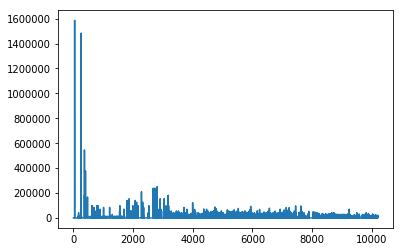

In [12]:
plt.plot(np.diff(a))

In [13]:
2736/52

52.61538461538461

In [14]:
data_catalogue['feature_1'].value_counts().sort_index()

1.006248e+02     42
1.587263e+06      1
1.601255e+06    117
1.615247e+06     14
1.657223e+06     17
1.671216e+06     66
3.154379e+06      1
3.182364e+06     11
3.196356e+06    102
3.742048e+06      1
3.756040e+06      3
3.937938e+06      1
3.951930e+06      1
4.119835e+06      4
4.133827e+06      1
4.161811e+06      4
4.217780e+06      2
4.231772e+06     17
4.609559e+06     66
4.623551e+06      1
4.637543e+06      1
4.805449e+06      7
4.819441e+06     85
4.833433e+06     58
4.847425e+06      1
4.903393e+06      2
5.001338e+06      7
5.029322e+06      1
5.127267e+06      5
5.141259e+06      2
               ... 
4.350591e+07      1
4.351385e+07      2
4.351581e+07      3
4.352182e+07      5
4.354689e+07      4
4.356379e+07      1
4.357778e+07      5
4.358348e+07      1
4.360117e+07      1
4.360578e+07     14
4.361447e+07      1
4.361977e+07      3
4.362631e+07      1
4.362674e+07      1
4.363377e+07      2
4.364946e+07      1
4.367036e+07      2
4.367682e+07      2
4.368974e+07      2


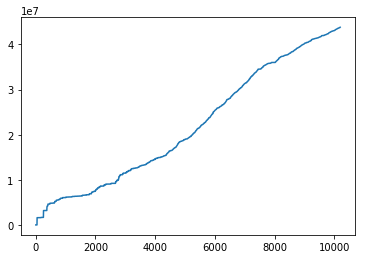

In [15]:
plt.plot(np.cumsum((np.diff(a))))

In [16]:
data_catalogue.drop('type',axis = 1).values.shape

(10200, 11)

In [17]:
data_catalogue.to_pickle(PREPARED_PATH+'data_catalogue.pkl')

In [ ]:
match_element_row = {i:ii for ii,i in enumerate(data_catalogue.index.values)}
match_row_element = {ii:i for ii,i in enumerate(data_catalogue.index.values)}
match_columns = [*list(data_catalogue.drop('type',axis = 1).columns),*(cv.get_feature_names())]
element_matrix = csr_matrix(np.hstack((data_catalogue.drop('type',axis = 1).values, X.A)))

In [ ]:
element_matrix

In [ ]:
import pickle
with open(PREPARED_PATH+'catalogue_features.pkl','wb') as f:
    pickle.dump((match_element_row,match_row_element,match_columns,element_matrix),f)

In [ ]:
import pickle
with open(PREPARED_PATH+'bag_of_attr_movie.pkl','wb') as f:
    pickle.dump(bag_of_attr,f)

In [ ]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

In [ ]:
%%time
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

In [ ]:
ratings.iloc[100]

In [ ]:
%%time
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)

In [ ]:
#Попробуем для каждого пользователя сделать некоторый путь потребления контента
# Для этого объединим все действия пользователей
transactions['action'] = 'watch'
ratings['action'] = 'rate'
bookmarks['action'] = 'bookmate'

In [ ]:
bookmarks.iloc[100]

In [ ]:
actions = pd.concat((transactions,ratings,bookmarks))

In [ ]:
actions.head()

`consumption_mode` — тип потребления (переменная принимает следующие значения: P — покупка, R — аренда, S — просмотр по подписке)

In [ ]:
actions.set_index(['user_uid','element_uid','ts'],inplace = True)

In [ ]:
actions.sort_index(inplace = True)

In [ ]:
one_user = actions.loc[207861]

In [ ]:
one_user

In [ ]:
data_catalogue.index.names = ['element_uid',]

In [ ]:
data_catalogue['duration'] = data_catalogue['duration']*60

In [ ]:
data_catalogue.head()

In [ ]:
#data_catalogue.loc[1570]

actions = actions.join(data_catalogue[['duration','type']])#.loc[(slice(None),[1570,],slice(None)),:]

In [ ]:
#actions.rating.value_counts()

In [ ]:
with open(os.path.join(DATA_PATH, 'test_users.json'), 'r') as f:
    test_users = set(json.load(f)['users'])

In [ ]:
len(test_users & set(actions.index.get_level_values(0)))

In [ ]:
# Приделаем каждому чуваку атрибуты просмотренных фильмов. ну или вообще по всем действиям - они все позитивные
ind_user = []
buf = []
for i in tqdm.tqdm(np.unique(actions.index.get_level_values(0))):
    temp = np.unique(actions.loc[i].index.get_level_values(0))
    ind_user.append(i)
    
    s = ''
    for ii in temp:
        s+=bag_of_attr[ii]
        
        s+=','
    if  '26846' in s:
            break
    #assert X.shape[1] == len(a)
    buf.append(s)
    
    

s

cv1 = CountVectorizer(token_pattern='\d+',)
X_user = cv1.fit_transform(buf)

In [ ]:
X_user.shape

In [ ]:
X.shape

In [ ]:
# Дальше уже совершенно ненужная херь, запускать до сюда


In [ ]:
len(cv1.get_feature_names())

In [ ]:
actions.head(20)#groupby('type')['duration'].median()/60


In [ ]:
# actions.device_manufacturer.value_counts()

In [ ]:
actions.consumption_mode.value_counts()

1 - фильм, 3 - сериал

Считается, что пользователь потребил контент, если он:
1. Купил его или взял в аренду
2. Посмотрел больше половины фильма по подписке
3. Посмотрел больше трети сериала по подписке


In [ ]:
actions.action.value_counts()

In [ ]:
%matplotlib inline

In [ ]:
def get_target(actions):
    '''
    Функция, которая вернет число просмотреннх серий каждым пользователем каждого сериала, потом вернет то,что недопотребил
    А потом то, что точно потребил согласно правилам соревнования - например, так можно вычислить примерную длительность сериала 
    и его же рекомендовать в потребленные после.
    '''
    watch_actions = actions[actions.action == 'watch']
    # Блок нахождения всяких статистик по сериалам
    serials = watch_actions[watch_actions['type'] == 3]
    # Заменим длиетльность на 0, там где длительности нет.. или это очень короткие, надо подумоть.
    serials['num_of_series'] = (serials['watched_time']/serials['duration']).fillna(0).replace(np.inf,0).astype(int)
    serials['time_being'] = serials.index.get_level_values(2)
    dur_being = serials.groupby(level = 1).agg({'time_being':[min,len],'num_of_series':[lambda x:x.mode()[0],max]})
    dur_being.columns = ['time_being','count_of_watch','num_of_series_mode','num_of_series_max']
    
    # Блок нахождения статистик по фильмам для пользователя
    films = watch_actions[watch_actions['type'] == 1]
    # Здесь важно видимо, как долго смотрел
    films['time_being'] = films.index.get_level_values(2)
    dur_films = films.groupby(level = 1).agg({'time_being':[min,len]})
    dur_films.columns = ['time_being','count_of_watch']
    
    # Блок нахождения статистик по фильмам и пользователям
    watch_actions['rel_dur'] = (watch_actions['watched_time']/watch_actions['duration'])
    watch_actions = watch_actions.groupby(level = [0,1]).mean()
    
    
    return dur_being,dur_films,watch_actions

In [ ]:
dur_being,dur_films,watch_actions = get_target(actions)

In [ ]:
# как там интересно распределно.
a = watch_actions['rel_dur'].replace(np.inf,-1,).fillna(-1)
ax = a[(np.percentile(a,1)<a) & (np.percentile(a,95)>=a) ].hist()
ax.axvline(x=np.median(a), color='k', linestyle='--')

In [ ]:
#  я б сказал, что это как-то некоторая окрестность единицы (мб по перцентилям - но тут надо подумать)- в ней фильмы просмотрены.
# За этой окрестностью справа - либо многосерийники, либо какая-то дичь
# слева - точно недосмотры.
# Можно попробовтаь какую-нить простую линейную модельку от атрибутов на 3 класса,( как вариант - регрессия просто)
# чтобы потом на коэффициенты взвесить атрибуты для полдьзователя (X_user)
#  а для фильмов - доля просмотров и недосмотров пользователям

In [ ]:
# Просто находит некоторые новинки и возвращает их  id
# Критерий скорее всего такой - строим ряд просмотров - 
# если их много прям с первой даты и дата не в начале списка - то новинка.
def min_nnz(x):
    if len(x[x!=0]) >0:
        return min(x[x!=0])
    else:
        return -1
def novice_detect(actions):
    watch_actions = actions[actions.action == 'watch']
    
    by_movie = watch_actions.groupby(level = [1,2])['action'].count().to_frame()
    by_movie.columns = ['by_time']
    al = watch_actions.groupby(level = [1])['action'].count().to_frame()
    by_movie = by_movie.join(al)
    by_movie['ts_time'] = by_movie.index.get_level_values(1)
    by_movie.sort_index(inplace = True)
    being_time = by_movie.groupby(level = [0])['ts_time'].agg(lambda x: x.iloc[0]).to_frame()
    being_time.columns = ['first_time']
    by_movie = by_movie.join(being_time)
    by_movie['diff_time'] = by_movie['ts_time'] - by_movie['first_time']
    by_movie['cum_watch'] = by_movie.groupby(level = [0,1])['by_time'].sum().groupby(level = 0).cumsum()
    by_movie['detect'] = by_movie['diff_time']/by_movie['cum_watch']
    by_movie['diff_time_all'] = by_movie.groupby(level = [0,1])['ts_time'].sum().groupby(level = 0).diff()
    res = by_movie.groupby(level = 0)['detect'].agg([min_nnz,max,np.mean,np.median])
    res = res.join(by_movie.groupby(level = 0)['diff_time_all'].mean())
    return res,by_movie

In [ ]:
a,by_movie = novice_detect(actions)

In [ ]:
#a.index = a.index.swaplevel()
a

In [ ]:
#a['cum_watch'] = a.groupby(level = [0,1])['by_time'].sum().groupby(level = 0).cumsum()

In [ ]:
#a.loc[a['min_nnz'] !=-1,'min_nnz'].hist()
ax = a.loc[a['mean']<np.median(a['mean']),'mean'].hist()
#ax.axvline(x=np.median(a['mean']), color='k', linestyle='--')

In [ ]:
# Вот тут надо подумать, что б такое было бы. что поможет детектировать новинки.
# Кажется, что их средние накопленные просмотры дб маленикими
# Только надо подумать

In [ ]:
a[a['min_nnz']!=-1].sort_values('mean').iloc[:10]

In [ ]:
a[a['min_nnz']!=-1].sort_values('mean').iloc[-10:]

In [ ]:
# Вообще, новинка должна перестать быть новинкой. нужно смотреть какой-нить перелом.
#  построим график какой-нибудь новинки

by_movie.loc[10073,'detect'].plot(figsize = (20,10))
# Т.е. со временем у него монотонно нарастает число просмотров за временной тик - вначале всплеск - 
# это и есть новизна и ее эффект скоротечен

In [ ]:
by_movie.loc[621,'detect'].plot(figsize = (20,10))

In [ ]:
#ToDo - некоторые фильмы смотрят подряд типа гарри поттер, властелин колец - попробовать найти такие последовательности

In [ ]:
watched_action = actions[actions.action == 'watch']
watched_action['ones'] = 1
watched_action_by_time = watched_action.groupby(level = 2).sum()

watched_action_by_time['ones'].rolling(10).sum().plot()

In [ ]:
watched_action['nearly_time'] = watched_action.index.get_level_values(2) - watched_action.index.get_level_values(2)%(24*60*60)
watched_action_by_time = watched_action.groupby('nearly_time').sum()

watched_action_by_time['ones'].plot()

In [ ]:
# Вот эти пики какие-то очень странные.надо подумать. и почему-то у накопленного числа просмотров
# резко в последней трети вырастает - значит либо изменился сервис, либо данные не очень уж случайно подобраны. Можно покопать туда
# ToDo

In [ ]:
# Проверим, что нормально можем поделить валидацию и прочее
watched_action_by_time = watched_action.groupby(level = 2).sum()
watched_action_by_time['cum_ones'] = np.cumsum(watched_action_by_time['ones'])

In [ ]:
watched_action_by_time['cum_ones'].plot()

In [ ]:
# Есть очень мелкая просадка посередине, ноннаверное не так уж и страшно и можно устроить трейн тест и валид по времени


In [ ]:
# ToDo корелляция между временем просмотра и рейтингами

ratings.set_index(['user_uid','element_uid'],inplace = True)
ratings.head()

In [ ]:
corr_df = pd.merge(ratings['rating'],watch_actions['rel_dur'],left_index=True,right_index=True)

In [ ]:
import seaborn as sns

In [ ]:
corr_df.replace(np.inf,np.nan).groupby('rating').agg([np.median,np.mean,min_nnz,np.max])


In [ ]:
#  С корелляцией как-то не особо пошло, а вот медиана говорит, что ваще-то не все далеко смотрят плохие фильмы до конца -
# бросают, гневаются уходят

In [ ]:
actions.to_pickle(PREPARED_PATH+'actions_one_table.pkl')

#### Вот до сюда считать

In [ ]:
len(set(cv1.get_feature_names())^set(cv.get_feature_names()))

In [ ]:
set(cv.get_feature_names())^set(cv1.get_feature_names())

In [ ]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Load the MovieLens 100k dataset. Only five
# star ratings are treated as positive.
data = fetch_movielens(min_rating=5.0)

# Instantiate and train the model
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

# Evaluate the trained model
test_precision = precision_at_k(model, data['test'], k=5).mean()